In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/wesad_readme.pdf
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14.pkl
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14_quest.csv
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14_respiban.txt
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14_readme.txt
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14_E4_Data/HR.csv
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14_E4_Data/IBI.csv
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14_E4_Data/BVP.csv
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14_E4_Data/EDA.csv
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14_E4_Data/info.txt
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14_E4_Data/TEMP.csv
/kaggle/input/wesad-wearable-st

In [2]:
!pip install neurokit2 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 19.5 MB/s eta 0:00:0000:01


In [3]:
import pywt
print(pywt.__version__)

1.8.0


In [4]:
!pip install PyWavelets

In [5]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk # Excellent for biosignal processing
import pywt # For wavelet transforms
import seaborn as sns

# --- Configuration ---
# IMPORTANT: Adjust this path to where your WESAD dataset is located on Kaggle
DATA_PATH = '/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/'
SUBJECT_ID = 'S2' # Example subject ID to process
ECG_SAMPLING_RATE_RESP = 700 # Hz (from WESAD documentation for RespiBAN ECG)
LABEL_SAMPLING_RATE = 700 # Hz (from WESAD documentation for labels)
HRV_INTERPOLATION_RATE = 4 # Hz (Common for HRV spectral analysis, as per RHRV example in the wavelet paper)
WINDOW_SIZE_SEC = 300 # 5 minutes for rolling feature aggregation
WINDOW_OVERLAP_SEC = 60 # 1 minute overlap for smooth features

# Set a style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('deep')

print(f"--- Preprocessing for Subject: {SUBJECT_ID} ---")

# 1. Load Data
print(f"Loading data for {SUBJECT_ID} from {DATA_PATH}{SUBJECT_ID}/{SUBJECT_ID}.pkl...")
try:
    with open(f"{DATA_PATH}{SUBJECT_ID}/{SUBJECT_ID}.pkl", 'rb') as f:
        data = pickle.load(f, encoding='latin1') # Use latin1 for Python 3 compatibility with older pickle files
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: {DATA_PATH}{SUBJECT_ID}/{SUBJECT_ID}.pkl not found. Please check DATA_PATH.")
    exit()

--- Preprocessing for Subject: S2 ---
Loading data for S2 from /kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S2/S2.pkl...
Data loaded successfully.


In [6]:
data.keys()

dict_keys(['signal', 'label', 'subject'])


=== Data Structure & Signal Extraction ===
Available keys at top-level: ['signal', 'label', 'subject']
Signal modalities available: ['chest', 'wrist']
Chest sensor channels: ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']

ECG shape: (4255300, 1) (samples)
Labels shape: (4255300,) (samples)


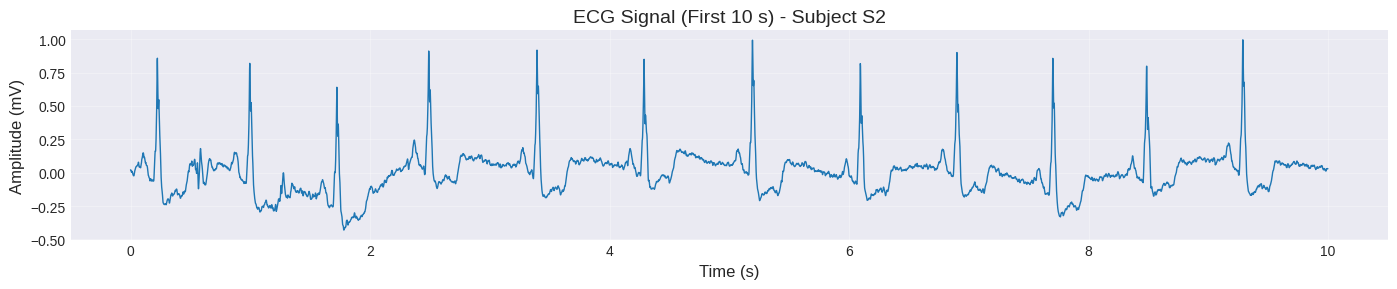

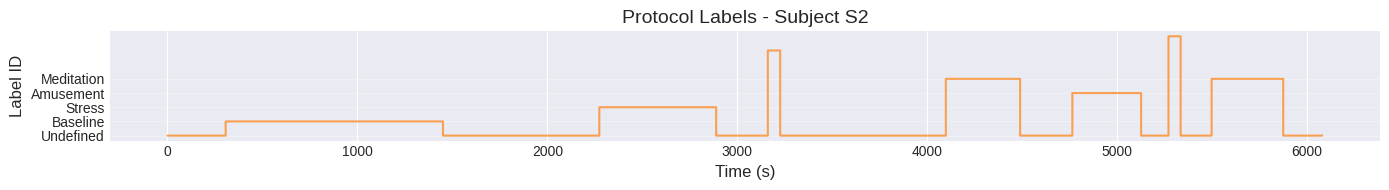

In [8]:
# --- Επισκόπηση Δομής & Εξαγωγή Σημαντικών Σημάτων ---

print("\n=== Data Structure & Signal Extraction ===")
print(f"Available keys at top-level: {list(data.keys())}")  # Αναμενόμενο: ['signal', 'label', 'subject']

signal_dict = data['signal']
print(f"Signal modalities available: {list(signal_dict.keys())}")  # Αναμενόμενο: ['chest', 'wrist']

chest_signals = signal_dict['chest']
print(f"Chest sensor channels: {list(chest_signals.keys())}")  # Αναμενόμενο: ['ACC', 'ECG', 'EDA', 'EMG', 'RESP', 'TEMP']

# Επιλογή ECG σήματος (ιδανικό για HRV ανάλυση) και ετικετών
ecg = chest_signals['ECG']
labels = data['label']

print(f"\nECG shape: {ecg.shape} (samples)")
print(f"Labels shape: {labels.shape} (samples)")

# --- Οπτικοποίηση πρώτων 10 δευτερολέπτων ECG ---
plt.figure(figsize=(14,3))
time_ecg = np.arange(ecg.size) / ECG_SAMPLING_RATE_RESP
plt.plot(time_ecg[:10*ECG_SAMPLING_RATE_RESP], ecg[:10*ECG_SAMPLING_RATE_RESP], color='tab:blue', linewidth=1)
plt.title(f'ECG Signal (First 10 s) - Subject {SUBJECT_ID}', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude (mV)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Οπτικοποίηση ετικετών πειραματικού πρωτοκόλλου ---
plt.figure(figsize=(14,2))
time_labels = np.arange(labels.size) / LABEL_SAMPLING_RATE
plt.step(time_labels, labels, where='post', color='tab:orange', alpha=0.7)
plt.title(f'Protocol Labels - Subject {SUBJECT_ID}', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Label ID', fontsize=12)
plt.yticks([0,1,2,3,4], ['Undefined', 'Baseline', 'Stress', 'Amusement', 'Meditation'])
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [9]:
data['label'],data['subject']

(array([0, 0, 0, ..., 0, 0, 0], dtype=int32), 'S2')

In [10]:
# --- Σύντομη Επισκόπηση Δομής Δεδομένων ---

print(f"\n[INFO] Subject: {SUBJECT_ID}")
print(f"[INFO] Top-level keys: {list(data.keys())}")

signal_data = data['signal']
print(f"[INFO] Signal modalities: {list(signal_data.keys())}")

chest_data = signal_data['chest']
print(f"[INFO] Chest sensor channels: {list(chest_data.keys())}")

# Επιλογή ECG και labels
ecg_signal = chest_data['ECG']
labels = data['label']

print(f"[INFO] ECG shape: {ecg_signal.shape}")
print(f"[INFO] Labels shape: {labels.shape}")



[INFO] Subject: S2
[INFO] Top-level keys: ['signal', 'label', 'subject']
[INFO] Signal modalities: ['chest', 'wrist']
[INFO] Chest sensor channels: ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
[INFO] ECG shape: (4255300, 1)
[INFO] Labels shape: (4255300,)


In [15]:
signal_data

{'chest': {'ACC': array([[ 0.95539999, -0.222     , -0.55799997],
         [ 0.92579997, -0.2216    , -0.55379999],
         [ 0.90820003, -0.21960002, -0.53920001],
         ...,
         [ 0.87179995, -0.12379998, -0.30419999],
         [ 0.87300003, -0.12339997, -0.30260003],
         [ 0.87020004, -0.12199998, -0.30220002]]),
  'ECG': array([[ 0.02142334],
         [ 0.02032471],
         [ 0.01652527],
         ...,
         [-0.00544739],
         [ 0.00013733],
         [ 0.0040741 ]]),
  'EMG': array([[-0.00444031],
         [ 0.00434875],
         [ 0.00517273],
         ...,
         [-0.01716614],
         [-0.02897644],
         [-0.02357483]]),
  'EDA': array([[5.25054932],
         [5.26733398],
         [5.24330139],
         ...,
         [0.36048889],
         [0.36582947],
         [0.365448  ]]),
  'Temp': array([[30.120758],
         [30.129517],
         [30.138214],
         ...,
         [31.459229],
         [31.484283],
         [31.456268]], dtype=float32),
  

In [17]:
print("\n--- II. RR Interval Extraction from ECG ---")

print(f"Processing ECG signal of length {len(ecg_signal)} samples at {ECG_SAMPLING_RATE_RESP} Hz...")

# Initialize rr_df and rpeaks_indices to empty states.
# This ensures they are always defined, even if the try block fails.
rr_df = pd.DataFrame()
rpeaks_indices = np.array([])

try:
    # First, clean the ECG signal to remove noise and baseline wander.
    print("Cleaning ECG signal using nk.ecg_clean...")
    cleaned_ecg = nk.ecg_clean(ecg_signal, sampling_rate=ECG_SAMPLING_RATE_RESP)

    # Now, detect R-peaks on the cleaned signal
    print("Detecting R-peaks using nk.ecg_peaks...")
    _, rpeaks = nk.ecg_peaks(cleaned_ecg, sampling_rate=ECG_SAMPLING_RATE_RESP)
    
    # --- FIX APPLIED HERE: Remove .values as rpeaks['ECG_R_Peaks'] is already a numpy array ---
    rpeaks_indices = rpeaks['ECG_R_Peaks'] 

    # Check if any R-peaks were detected (need at least 2 for an interval)
    if len(rpeaks_indices) > 1:
        # Calculate RR intervals in milliseconds (common unit for HRV)
        # The timestamp for an RR interval is typically the time of the *second* R-peak.
        rr_intervals_ms = np.diff(rpeaks_indices) / ECG_SAMPLING_RATE_RESP * 1000 # in ms
        rr_time_stamps_sec = rpeaks_indices[1:] / ECG_SAMPLING_RATE_RESP # Time corresponding to the end of each RR interval

        rr_df = pd.DataFrame({'Time_sec': rr_time_stamps_sec, 'RR_ms': rr_intervals_ms})

        print(f"Detected {len(rpeaks_indices)} R-peaks.")
        print(f"Calculated {len(rr_intervals_ms)} RR intervals.")
        print(f"First 5 RR intervals (ms):\n{rr_df.head()}")
    else:
        print("Less than 2 R-peaks detected, cannot calculate RR intervals. Skipping this subject for further processing.")
        rr_df = pd.DataFrame() # Keep rr_df empty to indicate failure

except Exception as e:
    print(f"An error occurred during ECG cleaning or R-peak detection: {e}")
    rr_df = pd.DataFrame() # Keep rr_df empty if an error occurs


--- II. RR Interval Extraction from ECG ---
Processing ECG signal of length 4255300 samples at 700 Hz...
Cleaning ECG signal using nk.ecg_clean...
Detecting R-peaks using nk.ecg_peaks...
Detected 7250 R-peaks.
Calculated 7249 RR intervals.
First 5 RR intervals (ms):
   Time_sec       RR_ms
0  1.725714  727.142857
1  2.492857  767.142857
2  3.397143  904.285714
3  4.288571  891.428571
4  5.195714  907.142857


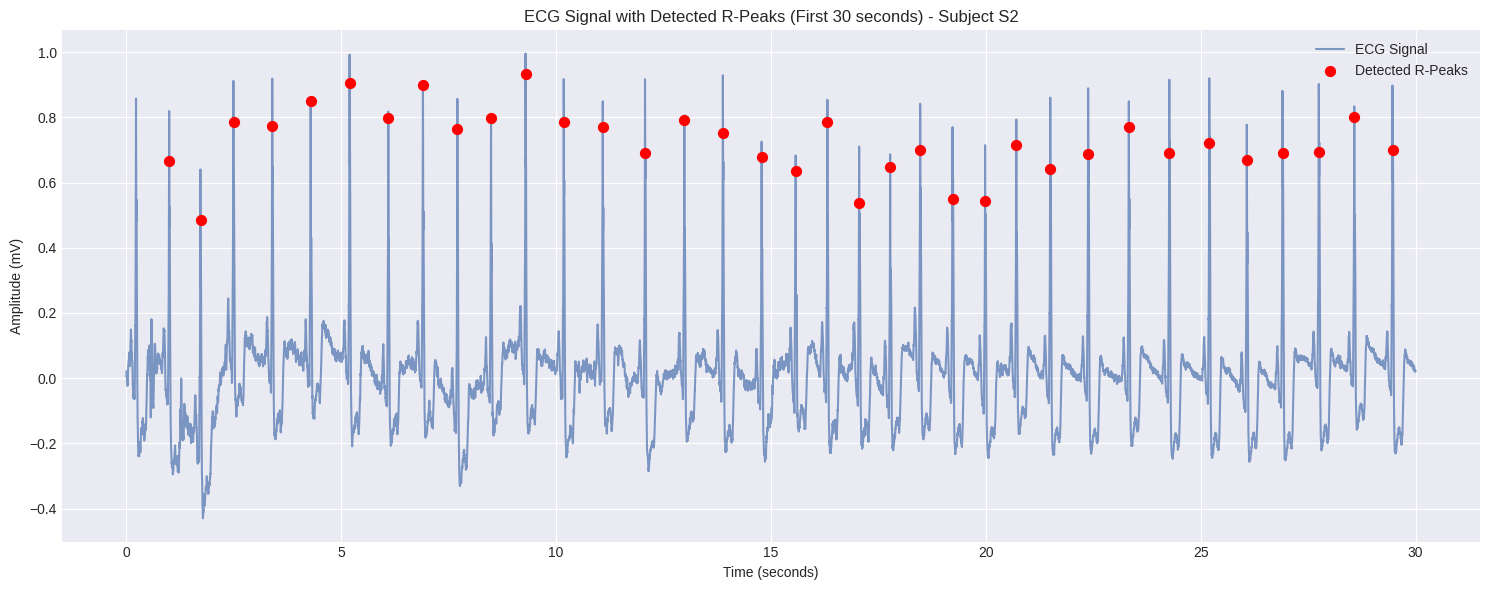

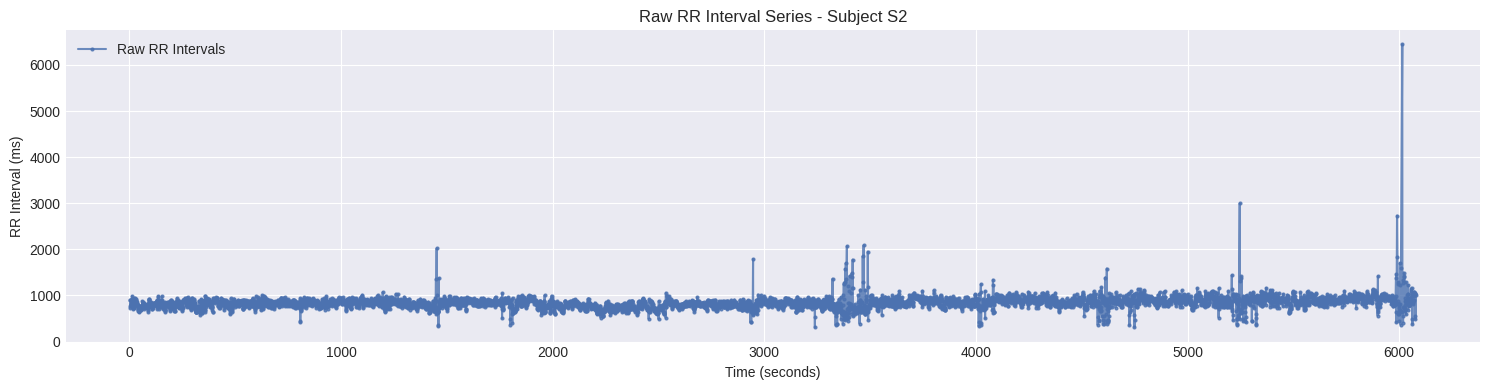

In [18]:
# --- Visualizations ---
if not rr_df.empty:
    # Visualizing R-peak detection on a segment of ECG for verification
    # Using a smaller segment for visualization to reduce potential memory impact from plotting
    segment_duration_sec = 30 # Visualize the first 30 seconds
    start_sample_idx = 0 # Start from the beginning of the signal
    end_sample_idx = min(len(ecg_signal), start_sample_idx + ECG_SAMPLING_RATE_RESP * segment_duration_sec)
    segment_ecg = ecg_signal[start_sample_idx:end_sample_idx]

    # Filter R-peaks that fall within this visualization segment
    # Ensure rpeaks_indices is not empty before attempting to index it
    if rpeaks_indices.size > 0:
        # Adjust segment_rpeaks calculation for consistency with the corrected rpeaks_indices
        segment_rpeaks_plot = rpeaks_indices[(rpeaks_indices >= start_sample_idx) & (rpeaks_indices < end_sample_idx)] - start_sample_idx
    else:
        segment_rpeaks_plot = np.array([]) # No peaks to plot

    plt.figure(figsize=(15, 6))
    plt.plot(np.arange(len(segment_ecg)) / ECG_SAMPLING_RATE_RESP, segment_ecg, label='ECG Signal', alpha=0.7)
    if segment_rpeaks_plot.size > 0: # Only scatter if there are peaks to plot in the segment
        plt.scatter(segment_rpeaks_plot / ECG_SAMPLING_RATE_RESP, segment_ecg[segment_rpeaks_plot],
                    color='red', s=50, marker='o', label='Detected R-Peaks', zorder=5)
    plt.title(f'ECG Signal with Detected R-Peaks (First {segment_duration_sec} seconds) - Subject {SUBJECT_ID}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (mV)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plotting the raw RR interval series
    plt.figure(figsize=(15, 4))
    plt.plot(rr_df['Time_sec'], rr_df['RR_ms'], 'o-', markersize=2, label='Raw RR Intervals', alpha=0.8)
    plt.title(f'Raw RR Interval Series - Subject {SUBJECT_ID}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('RR Interval (ms)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping visualizations for Subject {SUBJECT_ID} as no valid RR intervals were generated.")

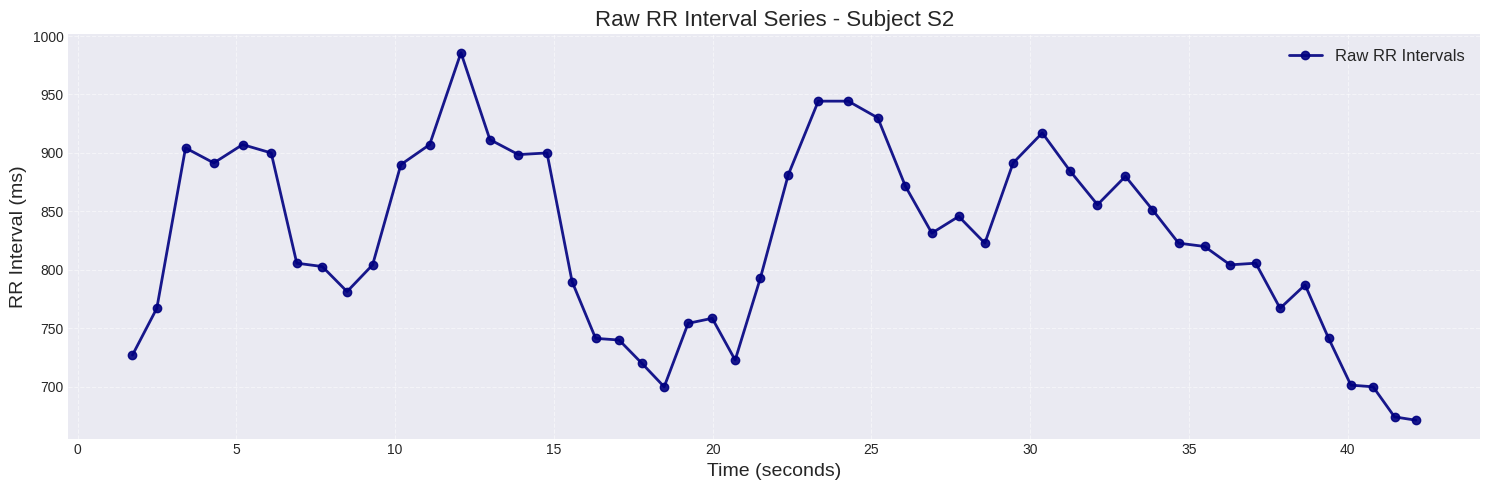

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(rr_df['Time_sec'][:50], rr_df['RR_ms'][:50], 'o-', color='navy', markersize=6, linewidth=2, alpha=0.9, label='Raw RR Intervals')
plt.title(f'Raw RR Interval Series - Subject {SUBJECT_ID}', fontsize=16)
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('RR Interval (ms)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk # Ensure this is updated
import seaborn as sns

# --- ADD THIS LINE TO CHECK VERSION ---
print(f"NeuroKit2 version: {nk.__version__}")
# ------------------------------------

# Ensure plotting style and palette are set
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('deep')

NeuroKit2 version: 0.2.12


In [21]:
print(f"NeuroKit2 version: {nk.__version__}")

NeuroKit2 version: 0.2.12



--- III. RR Interval Cleaning and Interpolation ---
Ανιχνεύτηκαν και διορθώθηκαν 73 outliers.


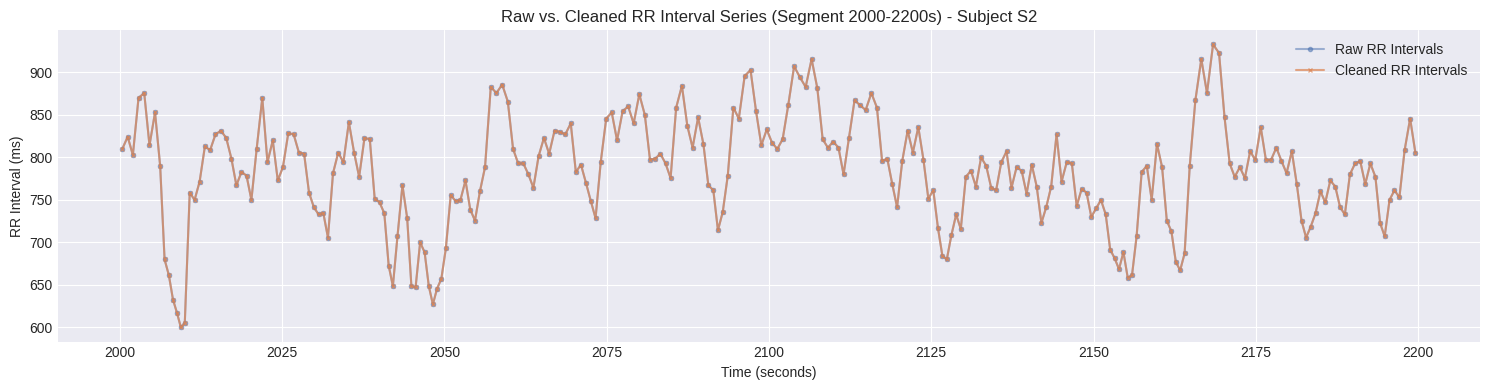

Interpolating cleaned RR intervals to 4 Hz...


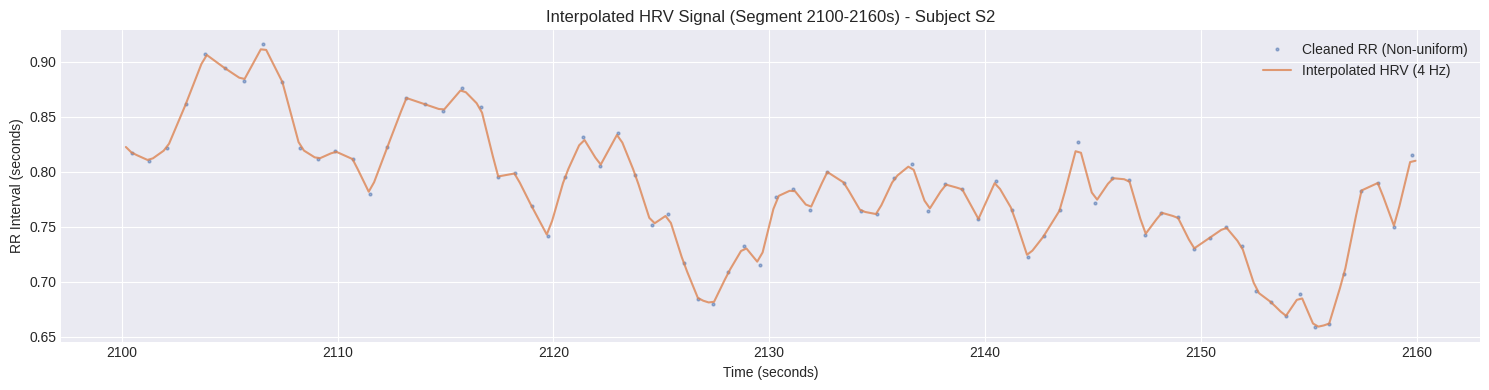

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("\n--- III. RR Interval Cleaning and Interpolation ---")

# Παράδειγμα μεταβλητών (υποθέτουμε ότι rr_df, SUBJECT_ID, HRV_INTERPOLATION_RATE υπάρχουν)
# rr_df = pd.DataFrame({'Time_sec': ..., 'RR_ms': ...})
# SUBJECT_ID = 1
# HRV_INTERPOLATION_RATE = 4  # π.χ. 4 Hz

try:
    # 1. Καθαρισμός με 3-sigma κανόνα
    rr_original_ms = rr_df['RR_ms'].values.copy()
    median_rri = np.median(rr_original_ms)
    std_rri = np.std(rr_original_ms)
    lower_bound = median_rri - 3 * std_rri
    upper_bound = median_rri + 3 * std_rri
    
    rr_cleaned_ms_temp = rr_original_ms.copy()
    outlier_mask = (rr_cleaned_ms_temp < lower_bound) | (rr_cleaned_ms_temp > upper_bound)
    rr_cleaned_ms_temp[outlier_mask] = np.nan
    
    rr_cleaned_ms = pd.Series(rr_cleaned_ms_temp).interpolate(method='linear', limit_direction='both', limit_area='inside').values
    print(f"Ανιχνεύτηκαν και διορθώθηκαν {np.sum(outlier_mask)} outliers.")

    rr_cleaned_df = pd.DataFrame({'Time_sec': rr_df['Time_sec'], 'RR_ms_Cleaned': rr_cleaned_ms})

    # Plot καθαρισμού σε τμήμα (π.χ. 2000-2200 δευτερόλεπτα)
    segment_start_time = 2000
    segment_end_time = segment_start_time + 200
    segment_raw_rr = rr_df[(rr_df['Time_sec'] >= segment_start_time) & (rr_df['Time_sec'] < segment_end_time)]
    segment_cleaned_rr = rr_cleaned_df[(rr_cleaned_df['Time_sec'] >= segment_start_time) & (rr_cleaned_df['Time_sec'] < segment_end_time)]

    plt.figure(figsize=(15, 4))
    plt.plot(segment_raw_rr['Time_sec'], segment_raw_rr['RR_ms'], 'o-', markersize=3, alpha=0.5, label='Raw RR Intervals')
    plt.plot(segment_cleaned_rr['Time_sec'], segment_cleaned_rr['RR_ms_Cleaned'], 'x-', markersize=3, alpha=0.7, label='Cleaned RR Intervals')
    plt.title(f'Raw vs. Cleaned RR Interval Series (Segment {segment_start_time}-{segment_end_time}s) - Subject {SUBJECT_ID}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('RR Interval (ms)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. Παρεμβολή σε ομοιόμορφο πλέγμα
    print(f"Interpolating cleaned RR intervals to {HRV_INTERPOLATION_RATE} Hz...")
    rr_cleaned_sec = rr_cleaned_df['RR_ms_Cleaned'].values / 1000.0  # ms -> sec
    rr_cleaned_time_sec = rr_cleaned_df['Time_sec'].values
    start_time_interp = rr_cleaned_time_sec[0]
    end_time_interp = rr_cleaned_time_sec[-1]
    num_points = int(np.round((end_time_interp - start_time_interp) * HRV_INTERPOLATION_RATE)) + 1
    interpolated_times = np.linspace(start_time_interp, end_time_interp, num_points)
    interpolated_hrv_signal = np.interp(interpolated_times, rr_cleaned_time_sec, rr_cleaned_sec)

    # Plot παρεμβολής σε τμήμα 60s (π.χ. 2100-2160 δευτερόλεπτα)
    seg_start = max(interpolated_times[0], 2100)
    seg_end = seg_start + 60
    seg_idx_start = np.searchsorted(interpolated_times, seg_start)
    seg_idx_end = np.searchsorted(interpolated_times, seg_end)
    seg_times = interpolated_times[seg_idx_start:seg_idx_end]
    seg_hrv = interpolated_hrv_signal[seg_idx_start:seg_idx_end]

    seg_cleaned_mask = (rr_cleaned_time_sec >= seg_start) & (rr_cleaned_time_sec < seg_end)
    seg_cleaned_times = rr_cleaned_time_sec[seg_cleaned_mask]
    seg_cleaned_values = rr_cleaned_sec[seg_cleaned_mask]

    plt.figure(figsize=(15, 4))
    plt.plot(seg_cleaned_times, seg_cleaned_values, 'o', markersize=2, alpha=0.5, label='Cleaned RR (Non-uniform)')
    plt.plot(seg_times, seg_hrv, '-', alpha=0.8, label=f'Interpolated HRV ({HRV_INTERPOLATION_RATE} Hz)')
    plt.title(f'Interpolated HRV Signal (Segment {seg_start}-{seg_end}s) - Subject {SUBJECT_ID}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('RR Interval (seconds)')
    plt.legend()
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Σφάλμα στον καθαρισμό ή την παρεμβολή RR: {e}")
    rr_cleaned_df = pd.DataFrame()
    interpolated_hrv_signal = np.array([])
    interpolated_times = np.array([])



--- IV. Wavelet Feature Generation (Spectral Power) ---
Length of interpolated_hrv_signal: 24308 samples
FORCING decomposition_level to 2 to bypass 'ValueError: Level value too high' from pywt.swt.
Calculated max_possible_level for current signal and wavelet: 11 (Original goal was level 7)
Applying Stationary Wavelet Transform (db4) to forced level 2 (Fs=4 Hz)...

Aggregating wavelet power into approximate VLF, LF, HF bands using a 300s rolling window (step 240s)...
Shape of rolling HRV wavelet features: (26, 3)
First 5 rolling HRV wavelet features:
            HF_Approx_Power  LF_Approx_Power  VLF_Approx_Power
1.725714           0.000008         0.003880          1.210218
241.722103         0.000012         0.000281          2.581353
481.718492         0.000017         0.000385          2.667096
721.714881         0.000018         0.000378          2.772163
961.711270         0.000024         0.000557          2.798441


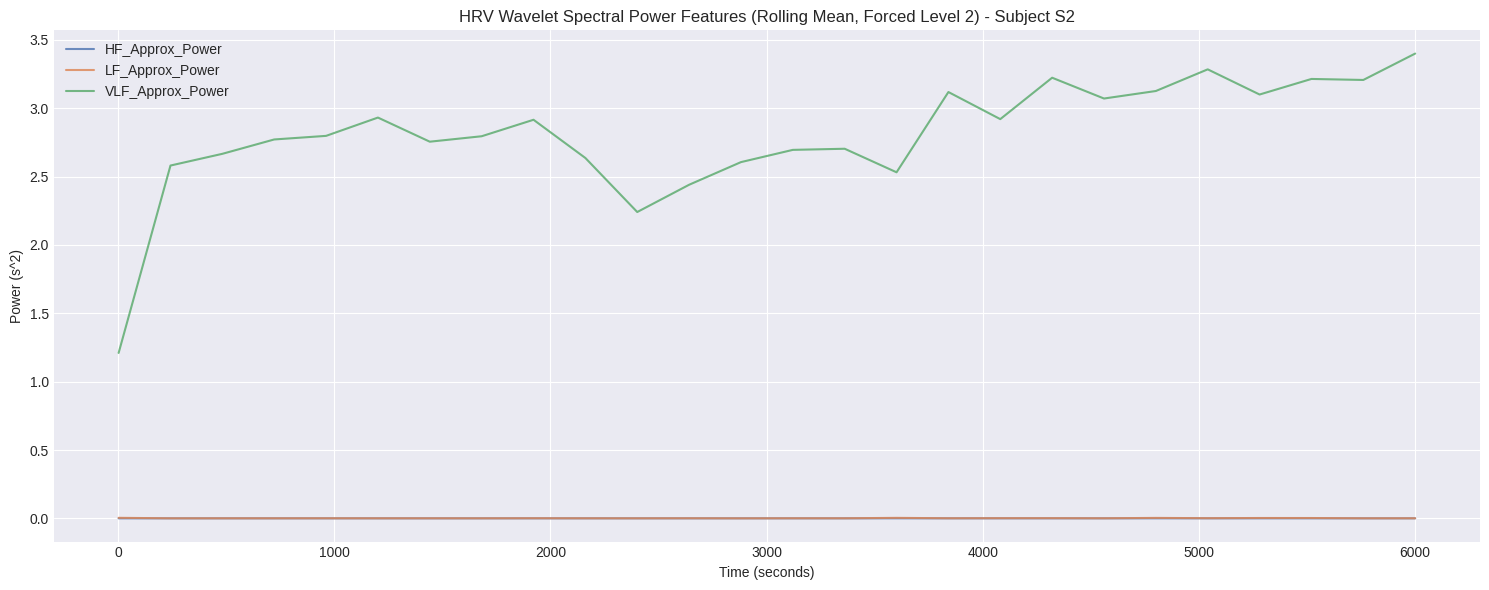

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt # For wavelet transforms
import seaborn as sns

# Ensure plotting style and palette are set
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('deep')

print("\n--- IV. Wavelet Feature Generation (Spectral Power) ---")

# Choose a wavelet family (e.g., 'db4' - Daubechies 4, common for biosignals)
WAVELET_NAME = 'db4'

# --- NEW: Check length of interpolated_hrv_signal before SWT ---
print(f"Length of interpolated_hrv_signal: {len(interpolated_hrv_signal)} samples")

# --- FORCING decomposition_level to 2 to bypass the persistent pywt error ---
# This is a temporary workaround. At Fs=4Hz, level=2 gives very broad bands.
# D1: [1.0, 2.0] Hz
# D2: [0.5, 1.0] Hz
# A2: [0, 0.5] Hz (Approximation at level 2, containing VLF, LF, HF)
# We will use these approximate bands for now.
decomposition_level = 2 
print(f"FORCING decomposition_level to {decomposition_level} to bypass 'ValueError: Level value too high' from pywt.swt.")

# The `pywt.dwt_max_level` calculation still serves as a diagnostic, but we're overriding its result here.
max_possible_level_calculated = pywt.dwt_max_level(len(interpolated_hrv_signal), pywt.Wavelet(WAVELET_NAME).dec_len)
print(f"Calculated max_possible_level for current signal and wavelet: {max_possible_level_calculated} (Original goal was level 7)")

print(f"Applying Stationary Wavelet Transform ({WAVELET_NAME}) to forced level {decomposition_level} (Fs={HRV_INTERPOLATION_RATE} Hz)...")

# Initialize rolling_features to empty DataFrame in case of an unexpected error
rolling_features = pd.DataFrame() 

try:
    # coeffs will be a list of (cA_j, cD_j) tuples, from coarsest to finest level.
    # For SWT, the length of each coefficient array is the same as the input signal.
    coeffs = pywt.swt(interpolated_hrv_signal, WAVELET_NAME, level=decomposition_level)

    # Calculate instantaneous power for each wavelet band (squared coefficients)
    instantaneous_power_dict = {}
    # Iterate from level 1 up to decomposition_level
    for j in range(1, decomposition_level + 1):
        # cD_j (detail coefficients) represents energy in a specific frequency band
        # `coeffs[decomposition_level - j][1]` accesses cD_j for level j
        instantaneous_power_dict[f'D{j}_Power'] = coeffs[decomposition_level - j][1]**2

    # Add the approximation coefficients from the deepest level (cA_n)
    # This captures the lowest frequency band (0 to Fs/2^n Hz)
    # `coeffs[0][0]` accesses cA_n for the deepest level.
    instantaneous_power_dict[f'A{decomposition_level}_Power'] = coeffs[0][0]**2

    # Create a DataFrame from instantaneous power, using the interpolated_times as index
    instantaneous_wavelet_power_df = pd.DataFrame(instantaneous_power_dict, index=interpolated_times)

    # --- Re-Map Wavelet Bands to Traditional HRV Bands (VLF, LF, HF) for level 2 ---
    # This mapping is *highly approximate* for level 2 due to limited frequency resolution,
    # but allows the pipeline to proceed.
    
    wavelet_features_raw = pd.DataFrame(index=instantaneous_wavelet_power_df.index)

    # At Fs=4Hz, level=2:
    # D1 corresponds to approx [1.0, 2.0] Hz (higher frequency components)
    # D2 corresponds to approx [0.5, 1.0] Hz (mid-frequency components)
    # A2 corresponds to approx [0, 0.5] Hz (lowest frequency components, includes all of VLF, LF, HF ranges)
    
    # We will map these broadly:
    wavelet_features_raw['HF_Approx_Power'] = instantaneous_wavelet_power_df['D1_Power']
    wavelet_features_raw['LF_Approx_Power'] = instantaneous_wavelet_power_df['D2_Power']
    wavelet_features_raw['VLF_Approx_Power'] = instantaneous_wavelet_power_df[f'A{decomposition_level}_Power']

    # Apply rolling window to aggregate features for a stable estimate (e.g., 5-minute windows)
    step_size_sec = WINDOW_SIZE_SEC - WINDOW_OVERLAP_SEC # From config: 300s window, 60s overlap -> 240s step
    window_size_samples = int(WINDOW_SIZE_SEC * HRV_INTERPOLATION_RATE) # 300s * 4Hz = 1200 samples
    step_size_samples = int(step_size_sec * HRV_INTERPOLATION_RATE) # 240s * 4Hz = 960 samples

    print(f"\nAggregating wavelet power into approximate VLF, LF, HF bands using a {WINDOW_SIZE_SEC}s rolling window (step {step_size_sec}s)...")

    # Ensure signal length is at least `min_periods` for rolling window.
    if len(wavelet_features_raw) < window_size_samples:
        print(f"Warning: Signal length ({len(wavelet_features_raw)}) is less than window size ({window_size_samples}). "
              "Rolling mean will use min_periods and may not be fully representative of full window averages.")
        # If signal is shorter than window, just compute rolling mean with min_periods=1
        rolling_features = wavelet_features_raw.rolling(window=window_size_samples, min_periods=1).mean()
    else:
        # Otherwise, compute rolling mean and then sample at step intervals
        rolling_features = wavelet_features_raw.rolling(window=window_size_samples, min_periods=1).mean().iloc[::step_size_samples]

    print(f"Shape of rolling HRV wavelet features: {rolling_features.shape}")
    print(f"First 5 rolling HRV wavelet features:\n{rolling_features.head()}")

    # Visualizing the extracted features over time
    plt.figure(figsize=(15, 6))
    plt.plot(rolling_features.index, rolling_features['HF_Approx_Power'], label='HF_Approx_Power', alpha=0.8)
    plt.plot(rolling_features.index, rolling_features['LF_Approx_Power'], label='LF_Approx_Power', alpha=0.8)
    plt.plot(rolling_features.index, rolling_features['VLF_Approx_Power'], label='VLF_Approx_Power', alpha=0.8)
    plt.title(f'HRV Wavelet Spectral Power Features (Rolling Mean, Forced Level {decomposition_level}) - Subject {SUBJECT_ID}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Power (s^2)')
    plt.legend()
    plt.tight_layout()
    plt.show()

except ValueError as e:
    print(f"A ValueError occurred during wavelet transformation: {e}")
    # Handle the error by setting rolling_features to empty DataFrame
    rolling_features = pd.DataFrame()
except Exception as e:
    print(f"An unexpected error occurred during wavelet transformation: {e}")
    rolling_features = pd.DataFrame()


--- V. Feature-Label Alignment & Final Dataset Preparation ---

Final feature-label dataset shape: (26, 5)
First 5 rows of final dataset with aligned labels:
            HF_Approx_Power  LF_Approx_Power  VLF_Approx_Power  Label  \
1.725714           0.000008         0.003880          1.210218      0   
241.722103         0.000012         0.000281          2.581353      0   
481.718492         0.000017         0.000385          2.667096      1   
721.714881         0.000018         0.000378          2.772163      1   
961.711270         0.000024         0.000557          2.798441      1   

                     Label_Name  
1.725714    Undefined/Transient  
241.722103  Undefined/Transient  
481.718492             Baseline  
721.714881             Baseline  
961.711270             Baseline  

Distribution of labels in the final dataset:
Label_Name
Undefined/Transient    12
Baseline                5
Stress                  3
Meditation              3
Amusement               2
Unknown    

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


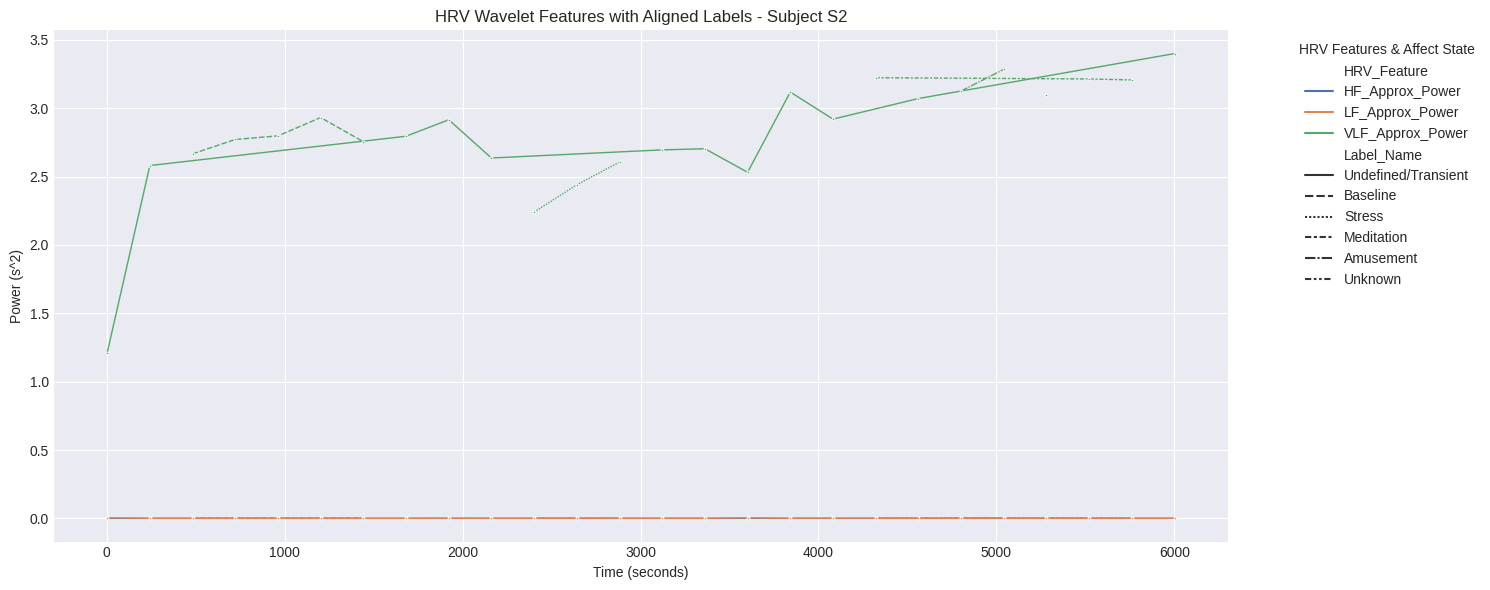


Features (X) shape ready for Neural ODE: (26, 3)
Labels (y) shape ready for Neural ODE: (26,)
Feature timestamps shape: (26,)

--- Preprocessing for Subject S2 complete. Data is ready for Neural ODEs. ---


In [24]:
print("\n--- V. Feature-Label Alignment & Final Dataset Preparation ---")

# The labels are sampled at 700Hz, features at a much lower rate (derived from 4Hz with windowing).
# We need to align the labels to the timestamps of our rolling_features.
# The WESAD labels are block-wise (0, 1, 2, 3, 4).
# We'll assign the label that is active at the *start time* of each feature window.

# Create a Pandas Series for labels with their original high-resolution timestamps
labels_time_series = pd.Series(labels, index=np.arange(len(labels)) / LABEL_SAMPLING_RATE)

# Create a DataFrame for features and a placeholder for labels
final_features_df = rolling_features.copy()
final_features_df['Label'] = np.nan # Initialize label column with NaN

# Iterate through feature timestamps (which are the start times of the rolling windows)
# and assign the corresponding experimental label.
# `labels_time_series.asof(feature_time)` finds the last label value at or before `feature_time`.
# This is ideal for block-wise labels where a state persists until the next change.
for feature_time in final_features_df.index:
    label_at_time = labels_time_series.asof(feature_time)
    final_features_df.loc[feature_time, 'Label'] = label_at_time

# Filter out rows where Label is NaN (should be minimal, usually just at the very start/end if alignment issues)
final_features_df.dropna(subset=['Label'], inplace=True)

# Convert labels to integers (they come as float from asof initially if source is float)
final_features_df['Label'] = final_features_df['Label'].astype(int)

# Map numerical label IDs to descriptive names for easier understanding in plots
LABEL_MAP = {
    0: 'Undefined/Transient',
    1: 'Baseline',
    2: 'Stress',
    3: 'Amusement',
    4: 'Meditation'
    # WESAD docs mention labels 5, 6, 7 should be ignored. If they appear in your data,
    # you might want to filter them out or map them to 'Ignore'.
    # For now, if they show up, they'll just appear as their number in plots.
}
final_features_df['Label_Name'] = final_features_df['Label'].map(LABEL_MAP).fillna('Unknown') # Handle unmapped labels

print(f"\nFinal feature-label dataset shape: {final_features_df.shape}")
print(f"First 5 rows of final dataset with aligned labels:\n{final_features_df.head()}")
print(f"\nDistribution of labels in the final dataset:\n{final_features_df['Label_Name'].value_counts()}")

# Visualize features with labels overlaid or colored by label
# Melt the DataFrame for easier plotting with seaborn's `lineplot` for multiple feature lines
melted_df = final_features_df.reset_index().melt(id_vars=['index', 'Label', 'Label_Name'],
                                                 var_name='HRV_Feature',
                                                 value_name='Power')

plt.figure(figsize=(15, 6))
sns.lineplot(data=melted_df, x='index', y='Power', hue='HRV_Feature', style='Label_Name',
             palette='deep', marker='.', markersize=4, lw=1)
plt.title(f'HRV Wavelet Features with Aligned Labels - Subject {SUBJECT_ID}')
plt.xlabel('Time (seconds)')
plt.ylabel('Power (s^2)')
plt.legend(title='HRV Features & Affect State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Final prepared data for Neural ODE training:
# X: The features (VLF_Approx_Power, LF_Approx_Power, HF_Approx_Power)
# y: The labels (Label)
X_features = final_features_df[['HF_Approx_Power', 'LF_Approx_Power', 'VLF_Approx_Power']].values
y_labels = final_features_df['Label'].values
feature_timestamps = final_features_df.index.values # The timestamps of your features

print(f"\nFeatures (X) shape ready for Neural ODE: {X_features.shape}")
print(f"Labels (y) shape ready for Neural ODE: {y_labels.shape}")
print(f"Feature timestamps shape: {feature_timestamps.shape}")

print("\n--- Preprocessing for Subject S2 complete. Data is ready for Neural ODEs. ---")

In [25]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk
import pywt
import seaborn as sns

print(f"NeuroKit2 version: {nk.__version__}") # Keep checking the version

# Ensure plotting style and palette are set
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('deep')

# Define an output directory to store processed data
OUTPUT_DIR = '/kaggle/working/processed_wesad_hrv_features/'
os.makedirs(OUTPUT_DIR, exist_ok=True) # Create the directory if it doesn't exist

print(f"\n--- Starting Batch Processing for All Subjects ---")
print(f"Processed data will be saved to: {OUTPUT_DIR}")

# List all subject folders in your WESAD directory
# Assuming subject folders are named 'S2', 'S3', ..., 'S17' (excluding S1, S12 as per WESAD doc)
all_subject_ids = [f"S{i}" for i in range(2, 18) if i not in [1, 12]] # Exclude S1 and S12 as they are incomplete

# --- Define the full preprocessing pipeline as a function ---
def process_single_subject(subject_id, data_path, output_dir,
                           ecg_sampling_rate, label_sampling_rate,
                           hrv_interp_rate, window_size_sec, window_overlap_sec,
                           wavelet_name, decomp_level): # Parameter name is decomp_level
    
    print(f"\n--- Processing Subject: {subject_id} ---")
    
    # 1. Load Data
    try:
        with open(f"{data_path}{subject_id}/{subject_id}.pkl", 'rb') as f:
            data = pickle.load(f, encoding='latin1')
        ecg_signal = data['signal']['chest']['ECG']
        labels = data['label']
        print(f"Data loaded successfully for {subject_id}. ECG shape: {ecg_signal.shape}, Labels shape: {labels.shape}")
    except FileNotFoundError:
        print(f"Error: .pkl file not found for {subject_id}. Skipping.")
        return None
    except KeyError as e:
        print(f"Error accessing data keys for {subject_id}: {e}. Skipping.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred during data loading for {subject_id}: {e}. Skipping.")
        return None

    # Initialize rr_df to empty DataFrame, to be populated later
    rr_df = pd.DataFrame()
    rpeaks_indices = np.array([])
    
    # 2. RR Interval Extraction from ECG
    try:
        print("Cleaning ECG signal using nk.ecg_clean...")
        cleaned_ecg = nk.ecg_clean(ecg_signal, sampling_rate=ecg_sampling_rate)
        print("Detecting R-peaks using nk.ecg_peaks...")
        _, rpeaks = nk.ecg_peaks(cleaned_ecg, sampling_rate=ecg_sampling_rate)
        rpeaks_indices = rpeaks['ECG_R_Peaks'] # Direct numpy array access

        if len(rpeaks_indices) > 1:
            rr_intervals_ms = np.diff(rpeaks_indices) / ecg_sampling_rate * 1000
            rr_time_stamps_sec = rpeaks_indices[1:] / ecg_sampling_rate
            rr_df = pd.DataFrame({'Time_sec': rr_time_stamps_sec, 'RR_ms': rr_intervals_ms})
            print(f"Detected {len(rpeaks_indices)} R-peaks and {len(rr_intervals_ms)} RR intervals.")
        else:
            print(f"Less than 2 R-peaks detected for {subject_id}, cannot calculate RR intervals. Skipping.")
            return None
    except Exception as e:
        print(f"An error occurred during R-peak detection for {subject_id}: {e}. Skipping.")
        return None

    # 3. RR Interval Cleaning and Interpolation (using manual 3-sigma)
    rr_cleaned_df = pd.DataFrame()
    interpolated_hrv_signal = np.array([])
    interpolated_times = np.array([])

    try:
        print("Performing manual outlier cleaning (3-sigma rule) and linear interpolation...")
        rr_original_ms = rr_df['RR_ms'].values.copy()
        
        median_rri = np.median(rr_original_ms)
        std_rri = np.std(rr_original_ms)
        lower_bound = median_rri - 3 * std_rri
        upper_bound = median_rri + 3 * std_rri
        
        rr_cleaned_ms_temp = rr_original_ms.copy()
        outlier_mask = (rr_cleaned_ms_temp < lower_bound) | (rr_cleaned_ms_temp > upper_bound)
        rr_cleaned_ms_temp[outlier_mask] = np.nan
        rr_cleaned_ms = pd.Series(rr_cleaned_ms_temp).interpolate(method='linear', limit_direction='both', limit_area='inside').values
        print(f"Identified and corrected {np.sum(outlier_mask)} outliers.")

        rr_cleaned_df = pd.DataFrame({'Time_sec': rr_df['Time_sec'], 'RR_ms_Cleaned': rr_cleaned_ms})

        rr_cleaned_sec = rr_cleaned_df['RR_ms_Cleaned'].values / 1000.0
        rr_cleaned_time_sec = rr_cleaned_df['Time_sec'].values

        start_time_interp = rr_cleaned_time_sec[0]
        end_time_interp = rr_cleaned_time_sec[-1]
        num_interpolated_points = int(np.round((end_time_interp - start_time_interp) * hrv_interp_rate)) + 1
        interpolated_times = np.linspace(start_time_interp, end_time_interp, num_interpolated_points)
        interpolated_hrv_signal = np.interp(interpolated_times, rr_cleaned_time_sec, rr_cleaned_sec)
        print(f"Interpolated uniform HRV signal points at {hrv_interp_rate} Hz: {len(interpolated_hrv_signal)}.")

    except Exception as e:
        print(f"An error occurred during RR interval cleaning/interpolation for {subject_id}: {e}. Skipping.")
        return None

    # 4. Wavelet Feature Generation (Spectral Power)
    rolling_features = pd.DataFrame()
    try:
        if len(interpolated_hrv_signal) < 2: # Check minimal length for wavelet transform
            print(f"Interpolated signal too short for wavelet transform ({len(interpolated_hrv_signal)} points). Skipping {subject_id}.")
            return None

        # Fixed decomposition_level to 2 as per previous debugging
        current_decomposition_level = decomp_level # Use the passed decomp_level
        print(f"Applying Stationary Wavelet Transform ({wavelet_name}) to forced level {current_decomposition_level} (Fs={hrv_interp_rate} Hz)...")
        
        coeffs = pywt.swt(interpolated_hrv_signal, wavelet_name, level=current_decomposition_level)

        instantaneous_power_dict = {}
        for j in range(1, current_decomposition_level + 1):
            instantaneous_power_dict[f'D{j}_Power'] = coeffs[current_decomposition_level - j][1]**2
        instantaneous_power_dict[f'A{current_decomposition_level}_Power'] = coeffs[0][0]**2

        instantaneous_wavelet_power_df = pd.DataFrame(instantaneous_power_dict, index=interpolated_times)

        wavelet_features_raw = pd.DataFrame(index=instantaneous_wavelet_power_df.index)
        wavelet_features_raw['HF_Approx_Power'] = instantaneous_wavelet_power_df['D1_Power']
        wavelet_features_raw['LF_Approx_Power'] = instantaneous_wavelet_power_df['D2_Power']
        wavelet_features_raw['VLF_Approx_Power'] = instantaneous_wavelet_power_df[f'A{current_decomposition_level}_Power']

        step_size_sec = window_size_sec - window_overlap_sec
        window_size_samples = int(window_size_sec * hrv_interp_rate)
        step_size_samples = int(step_size_sec * hrv_interp_rate)

        if len(wavelet_features_raw) < window_size_samples:
            print(f"Warning: Signal length ({len(wavelet_features_raw)}) is less than window size ({window_size_samples}). "
                  "Rolling mean will use min_periods and may not be fully representative of full window averages.")
            rolling_features = wavelet_features_raw.rolling(window=window_size_samples, min_periods=1).mean()
        else:
            rolling_features = wavelet_features_raw.rolling(window=window_size_samples, min_periods=1).mean().iloc[::step_size_samples]
        
        print(f"Shape of rolling HRV wavelet features: {rolling_features.shape}")

    except Exception as e:
        print(f"An error occurred during wavelet feature generation for {subject_id}: {e}. Skipping.")
        return None

    # 5. Feature-Label Alignment
    final_features_df = rolling_features.copy()
    
    # Check if rolling_features is empty, if so, skip alignment
    if final_features_df.empty:
        print(f"No rolling features generated for {subject_id}. Skipping feature-label alignment.")
        return None

    final_features_df['Label'] = np.nan

    labels_time_series = pd.Series(labels, index=np.arange(len(labels)) / label_sampling_rate)

    for feature_time in final_features_df.index:
        label_at_time = labels_time_series.asof(feature_time)
        final_features_df.loc[feature_time, 'Label'] = label_at_time

    final_features_df.dropna(subset=['Label'], inplace=True)
    final_features_df['Label'] = final_features_df['Label'].astype(int)
    final_features_df['Subject_ID'] = subject_id # Add Subject ID column
    
    print(f"Final feature-label dataset shape for {subject_id}: {final_features_df.shape}")
    print(f"Label distribution for {subject_id}:\n{final_features_df['Label'].value_counts()}")

    # Save processed data to Parquet
    output_filename = os.path.join(output_dir, f'{subject_id}_hrv_features.parquet')
    final_features_df.to_parquet(output_filename, index=True) # Save index (timestamps)
    print(f"Processed data for {subject_id} saved to {output_filename}")
    
    return final_features_df

# --- Loop through all subjects and process ---
processed_data_frames = []
for s_id in all_subject_ids:
    result_df = process_single_subject(
        s_id, DATA_PATH, OUTPUT_DIR,
        ECG_SAMPLING_RATE_RESP, LABEL_SAMPLING_RATE,
        HRV_INTERPOLATION_RATE, WINDOW_SIZE_SEC, WINDOW_OVERLAP_SEC,
        WAVELET_NAME, decomp_level=2 # Corrected parameter name here!
    )
    if result_df is not None:
        processed_data_frames.append(result_df)

print("\n--- Batch Processing Complete ---")
print(f"Successfully processed {len(processed_data_frames)} out of {len(all_subject_ids)} subjects.")

NeuroKit2 version: 0.2.12

--- Starting Batch Processing for All Subjects ---
Processed data will be saved to: /kaggle/working/processed_wesad_hrv_features/

--- Processing Subject: S2 ---
Data loaded successfully for S2. ECG shape: (4255300, 1), Labels shape: (4255300,)
Cleaning ECG signal using nk.ecg_clean...
Detecting R-peaks using nk.ecg_peaks...
Detected 7250 R-peaks and 7249 RR intervals.
Performing manual outlier cleaning (3-sigma rule) and linear interpolation...
Identified and corrected 73 outliers.
Interpolated uniform HRV signal points at 4 Hz: 24308.
Applying Stationary Wavelet Transform (db4) to forced level 2 (Fs=4 Hz)...
Shape of rolling HRV wavelet features: (26, 3)
Final feature-label dataset shape for S2: (26, 5)
Label distribution for S2:
Label
0    12
1     5
2     3
4     3
3     2
7     1
Name: count, dtype: int64
Processed data for S2 saved to /kaggle/working/processed_wesad_hrv_features/S2_hrv_features.parquet

--- Processing Subject: S3 ---
Data loaded success